In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData

In [2]:
import scipy

In [3]:
import copy

In [4]:
import time

In [5]:
import glob

In [6]:
class uvdata_pol_calibrator():
    
    def __init__(self, model_data=None, real_data=None, mode="model_based"):
        """
        Parameters
        ----------
        model_data, real_data : UVData
        
        mode : str
            Specify the way gains are aligned. Choices are "model_based" and "data_based".
            "model_based" means V_ij_data = G_i V_ij_model G_j^H,
            and "data_based" means V_ij_model = G_i V_ij_data G_j^H.
            
        """
        if mode == "model_based":
            self.base_data, self.prod_data = model_data, real_data
        if mode == "data_based":
            self.base_data, self.prod_data = real_data, model_data
        self.gain_array = np.zeros((self.base_data.Nants_data, self.base_data.Nfreqs, 2, 2)).astype(np.complex128)
        self.gain_H_array = np.zeros((self.base_data.Nants_data,self.base_data.Nfreqs, 2, 2)).astype(np.complex128)
        
    def data_slice(self, use_all_times=False, base_time_range=[], prod_time_range=[], use_all_frequencies=False, base_freq_range=[], prod_freq_range=[], 
                   use_all_ants=False, base_ants=[], prod_ants=[]):
        """
        Get a slice of the data.
        
        Parameters
        ----------

       


        """
        if use_all_ants:
            ants = np.unique(self.prod_data.ant_1_array)
        else:
            assert isinstance(base_ants, list) and isinstance(prod_ants, list), "ants must be a list." 
            base_ants, prod_ants= list(np.sort(base_ants)), list(np.sort(prod_ants))
            assert base_ants == prod_ants
            ants = prod_ants
        self.ants2cal = ants
        
        if use_all_times:
            base_time_range = [np.unique(self.base_data.time_array)[0]-1e-2, np.unique(self.base_data.time_array)[-1]+1e-2]
            prod_time_range = [np.unique(self.prod_data.time_array)[0]-1e-2, np.unique(self.prod_data.time_array)[-1]+1e-2]
        else:
            assert isinstance(base_time_range, list) and isinstance(prod_time_range, list), "time_range must be a list"
            assert len(base_time_range) == len(prod_time_range), "Length of time_ranges must be the same."
            assert len(base_time_range) == 2, "Length of time_range must be 2."
        
        if use_all_frequencies:
            base_freqs = list(range(self.base_data.Nfreqs))
            prod_freqs = list(range(self.prod_data.Nfreqs))
        else:
            assert isinstance(base_freq_range, list) and isinstance(prod_freq_range, list), "freq_range must be a list"
            assert base_freq_range == prod_freq_range, "freq_ranges must be the same."
            if len(base_freq_range) == 1:
                base_freqs = base_freq_range
                prod_freqs = prod_freq_range
            elif len(base_freq_range) == 2:
                base_freqs = list(range(base_freq_range[0],base_freq_range[1]+1))
                prod_freqs = list(range(prod_freq_range[0],prod_freq_range[1]+1))
            else:
                raise ValueError("Length of freq_range must be 1 or 2.")
        self.freqs2cal = prod_freqs
        
        base_data_slice = self.base_data.select(antenna_nums=ants, freq_chans=base_freqs, time_range=base_time_range, inplace=False) 
        prod_data_slice = self.prod_data.select(antenna_nums=ants, freq_chans=prod_freqs, time_range=prod_time_range, inplace=False)             
        
        # original data_array shape: (Nblts, Nspws, Nfreqs, )
        # intermidiate data_array shape: (Nants, Nants, Nspws, Ntimes, Nfreqs, Npols)
        # final data_array shape: (Nants, Nants, :, 2, 2)
        assert base_data_slice.data_array.shape == prod_data_slice.data_array.shape
        base_data_array = np.zeros((len(ants), len(ants), base_data_slice.Nspws, base_data_slice.Ntimes, base_data_slice.Nfreqs, base_data_slice.Npols)).astype(np.complex128)
        prod_data_array = np.zeros((len(ants), len(ants), prod_data_slice.Nspws, prod_data_slice.Ntimes, prod_data_slice.Nfreqs, prod_data_slice.Npols)).astype(np.complex128)
        
        for (i, ant1) in enumerate(ants):
            for (j,ant2) in enumerate(ants):
                for spw in range(base_data_slice.Nspws): 
                    if ant1 <= ant2:
                        baseline_number = 2048*(ant1+1)+(ant2+1)+2**16
                        # baseline index = 2048 * (ant1+1) + (ant2+1) + 2**16
                        base_data_array_copy = base_data_slice.get_data(baseline_number)
                        # uvdata.get_data() returns an array with a shape (Ntimes, Nfreqs, Npols) 
                        base_data_array[i,j,spw, :,:,0], base_data_array[i,j,spw, :,:,1],  base_data_array[i,j,spw, :,:,2],  base_data_array[i,j,spw, :,:,3] = base_data_array_copy[:,:,0], base_data_array_copy[:,:,2],  base_data_array_copy[:,:,3],  base_data_array_copy[:,:,1]
                        """
                        data_array orginally stores the polarization information as a 1d array [-5, -6, -7, -8], corresponding to [XX, YY, XY, YX].
                        Here we first modify it into [-5,-7, -8,-6], 
                        then we will modify it into a 2d array[[-5,-7],[-8,-6]], corresponding to [[XX, XY], [YX, YY]].
                        """
                        prod_data_array_copy = prod_data_slice.get_data(baseline_number)
                        prod_data_array[i,j,spw, :,:,0], prod_data_array[i,j,spw, :,:,1], prod_data_array[i,j,spw, :,:,2], prod_data_array[i,j,spw, :,:,3] = prod_data_array_copy[:,:,0], prod_data_array_copy[:,:,2], prod_data_array_copy[:,:,3], prod_data_array_copy[:,:,1]

                    if ant1 > ant2:
                        baseline_number = 2048*(ant2+1)+(ant1+1)+2**16
                        base_data_array_copy = np.conj(base_data_slice.get_data(baseline_number))
                        base_data_array[i,j,spw, :,:,0], base_data_array[i,j,spw, :,:,1],  base_data_array[i,j,spw, :,:,2],  base_data_array[i,j,spw, :,:,3] = base_data_array_copy[:,:,0], base_data_array_copy[:,:,3], base_data_array_copy[:,:,2], base_data_array_copy[:,:,1]
                        """
                        Since V_{ji} = V_{ij}^H, we should take conjugate values here and then reorder the pols as
                        [-5,-8, -7,-6], which becomes [[-5,-8],[-7,-6]] after converted into a 2d array.
                        """
                        prod_data_array_copy = np.conj(prod_data_slice.get_data(baseline_number))
                        prod_data_array[i,j,spw, :,:,0], prod_data_array[i,j,spw, :,:,1], prod_data_array[i,j,spw, :,:,2], prod_data_array[i,j,spw, :,:,3] = prod_data_array_copy[:,:,0], prod_data_array_copy[:,:,3], prod_data_array_copy[:,:,2], prod_data_array_copy[:,:,1]


        data_shape = base_data_array.shape
        base_data_array = base_data_array.reshape((data_shape[0], data_shape[1], data_shape[2], data_shape[3], data_shape[4], 2, 2))
        prod_data_array = prod_data_array.reshape((data_shape[0], data_shape[1], data_shape[2], data_shape[3], data_shape[4], 2, 2))
        # reshape the pols
        base_data_array = base_data_array.reshape((data_shape[0], data_shape[1], data_shape[2]*data_shape[3]*data_shape[4], 2, 2))
        prod_data_array = prod_data_array.reshape((data_shape[0], data_shape[1], data_shape[2]*data_shape[3]*data_shape[4], 2, 2))
        # concatenate axis to a shape (Nants, Nants, :, 2, 2)

        self.base_data_array,  self.prod_data_array = base_data_array, prod_data_array
        
    def Wirtinger_lm_cal(self, diagonalize=False, Niteration=50, including_autobaseline=False, verbose=False, epsilon=1e-12):
        """
        Using Newton-Gauss method to obtain calibration gains G which minimizing \sum{D_[ij]-G_i M_{ij} G_j^H}, where D, G and M are all 2*2 matrices. 
        Update each step: G_{k+1} = [J(G_k)^H J(G_k)]^{-1} * J(G_k)^H * D, where J is the Jacobian matrix. 

        Parameters
        ----------

       

        Returns
        -------

        gain : dict
            calibration gains

        residual : 

        """
        ants, prod, base = self.ants2cal, self.prod_data_array, self.base_data_array
        gain_prev = np.array([[1,0],[0,1]]).astype(np.complex128)
        gain_prev = np.repeat(gain_prev[np.newaxis,:,:], len(ants), axis=0)
        gain_H_prev = np.copy(gain_prev)
        gain_next, gain_H_next = np.zeros_like(gain_prev), np.zeros_like(gain_prev)
        
        residual = np.zeros(Niteration)

        for iteration in range(Niteration):
            for (i,ant) in enumerate(ants):
                JH_J = np.zeros((2,2)).astype(np.complex128)
                JH_D = np.zeros((2,2)).astype(np.complex128)
                for (j,ant_q) in enumerate(ants):
                    # sum over baselines, frequencies and times
                    JH_J += np.sum(np.matmul(base[i,j], np.matmul(gain_H_prev[j][None], np.matmul(gain_prev[j][None], base[j,i]))), axis=0)
                    JH_D += np.sum(np.matmul(prod[i,j], np.matmul(gain_prev[j][None], base[j, i])), axis=0)
                if not including_autobaseline:
                    # if not including auto-baseline
                    JH_J -= np.sum(np.matmul(base[i,i], np.matmul(gain_H_prev[i][None], np.matmul(gain_prev[i][None], base[i,i]))), axis=0)
                    JH_D -= np.sum(np.matmul(prod[i,i], np.matmul(gain_prev[i][None], base[i, i])), axis=0)         
                
                # For possible singular matrix, we add a very small diagonal matrix onto it to make it invertible.
                if np.isclose(np.linalg.det(JH_J),0):
                    JH_J += np.array([[epsilon,0],[0,epsilon]])   
                if diagonalize==True:
                    gain_next[i] = np.diag(np.diag(np.matmul(JH_D, np.linalg.inv(JH_J))))
                else:
                    gain_next[i] = np.matmul(JH_D, np.linalg.inv(JH_J))
                
                JH_J = np.zeros((2,2)).astype(np.complex128)
                JH_D = np.zeros((2,2)).astype(np.complex128)
                for (k,ant_p) in enumerate(ants):
                    JH_J += np.sum(np.matmul(base[i,k], np.matmul(gain_H_prev[k][None], np.matmul(gain_prev[k][None], base[k,i]))), axis=0)
                    JH_D += np.sum(np.matmul(base[i,k], np.matmul(gain_H_prev[k][None], prod[k, i])), axis=0)     
                if not including_autobaseline:
                    JH_J -= np.sum(np.matmul(base[i,i], np.matmul(gain_H_prev[i][None], np.matmul(gain_prev[i][None], base[i,i]))), axis=0)
                    JH_D -= np.sum(np.matmul(base[i,i], np.matmul(gain_H_prev[i][None], prod[i, i])), axis=0)  
                
                if np.isclose(np.linalg.det(JH_J),0):
                    JH_J += np.array([[epsilon,0],[0,epsilon]])
                if diagonalize==True:
                    gain_H_next[i] = np.diag(np.diag(np.matmul(np.linalg.inv(JH_J), JH_D)))
                else:
                    gain_H_next[i] = np.matmul(np.linalg.inv(JH_J), JH_D)
            
            # Rephase to one antenna feed to reduce the degeneracies
            gain_prev = gain_next*np.exp(-1.j*np.angle(gain_next[0,0,0]))
            gain_H_prev = gain_H_next*np.exp(1.j*np.angle(gain_next[0,0,0]))

            for ant in range(len(ants)):
                for ant_r in range(len(ants)):
                    if including_autobaseline:
                         residual[iteration] += np.linalg.norm(prod[ant,ant_r] - np.matmul(gain_prev[ant][None], np.matmul(base[ant,ant_r], gain_H_prev[ant_r][None])))
                    else:
                        if ant_r != ant:
                            residual[iteration] += np.linalg.norm(prod[ant,ant_r] - np.matmul(gain_prev[ant][None], np.matmul(base[ant,ant_r], gain_H_prev[ant_r][None])))
        
        # Add results to self.gain_array
        ants_all = np.unique(self.prod_data.ant_1_array)
        for i, ant in enumerate(ants):
            ant_index = np.where(ants_all==ant)
            for freq_index in self.freqs2cal:
                self.gain_array[ant_index, freq_index,:,:] = gain_prev[i,:,:]
                self.gain_H_array[ant_index, freq_index,:,:] = gain_H_prev[i,:,:]

        if verbose:
            print(residual)                    






In [22]:
 from scipy import interpolate

In [26]:
def gain_array_interpolate(gain_array, interpolate_freq_index):
    """
    Parameters
    ----------
    
    """
    # Get amplitudes and phases of the gain_array 
    gain_amp = abs(gain_array)
    gain_phs = np.angle(gain_array)
    gain_phs[np.where(gain_phs<0)] += 2*np.pi
    gain_array_interp = np.zeros_like(gain_array).astype(np.complex128)
    freqs = np.arange(gain_array.shape[1])
    for ant in range(gain_array.shape[0]):
        for i in range(2):
            for j in range(2):
                interpolate_amp = interpolate.interp1d(interpolate_freq_index, gain_amp[ant,interpolate_freq_index,i,j],fill_value="extrapolate")
                interpolate_phs = interpolate.interp1d(interpolate_freq_index, gain_phs[ant,interpolate_freq_index,i,j],fill_value="extrapolate")
                gain_array_interp[ant,:,i,j] = interpolate_amp(freqs)*np.exp(1.j*interpolate_phs(freqs))
    return gain_array_interp

In [44]:
def apply_gains(uvd, gain_array_, need_interpolate=False, interpolate_freq_index=None, need_inverse=True, epsilon=1e-12):
    """
    Parameters
    ----------
    
    """
    gain_array = copy.deepcopy(gain_array_)
    if need_interpolate:
        if interpolate_freq_index is not None:
            gain_array = gain_array_interpolate(gain_array, interpolate_freq_index)
    if need_inverse:
        for ant_index in range(gain_array.shape[0]):
            for freq_index in range(gain_array.shape[0]):
                # For possible singular matrix, we add a very small diagonal matrix onto it to make it invertible.
                if np.isclose(np.linalg.det(gain_array[ant_index,freq_index]),0):
                    gain_array[ant_index,freq_index] += np.array([[epsilon,0],[0,epsilon]]) 
                gain_array[ant_index,freq_index] = np.linalg.inv(gain_array[ant_index,freq_index])
        
    
    ant_dicts = dict(enumerate(np.unique(uvd.ant_1_array)))
    ant_dicts = dict((v,k) for k,v in ant_dicts.items())
    ant_1_gain_array = []
    for ant in uvd.ant_1_array[0:uvd.Nbls]:
        ant_index = ant_dicts[ant]
        ant_1_gain_array.append(gain_array[ant_index,:,:,:])
    ant_1_gain_array = np.array(ant_1_gain_array)
    ant_1_gain_array = ant_1_gain_array[:,None,:,:,:]
    ant_1_gain_array = np.tile(ant_1_gain_array, (uvd.Ntimes,1,1,1,1))
    
    ant_2_gain_array = []
    for ant in uvd.ant_2_array[0:uvd.Nbls]:
        ant_index = ant_dicts[ant]
        ant_2_gain_array.append(gain_array[ant_index,:,:,:])
    ant_2_gain_array = np.array(ant_2_gain_array)
    ant_2_gain_array = ant_2_gain_array[:,None,:,:,:]
    ant_2_gain_array = np.tile(ant_2_gain_array,(uvd.Ntimes,1,1,1,1))
    ant_2_gain_array = np.conj(ant_2_gain_array)
    ant_2_gain_array = np.transpose(ant_2_gain_array, (0,1,2,4,3))
    
    raw_data_array = np.zeros_like(uvd.data_array).astype(np.complex128)
    raw_data_array[:,:,:,0], raw_data_array[:,:,:,1],  raw_data_array[:,:,:,2],  raw_data_array[:,:,:,3] = uvd.data_array[:,:,:,0], uvd.data_array[:,:,:,2], uvd.data_array[:,:,:,3], uvd.data_array[:,:,:,1]
    raw_data_array = raw_data_array.reshape((raw_data_array.shape[0],raw_data_array.shape[1], raw_data_array.shape[2],2,2))
    
    cal_data_array = np.matmul(ant_1_gain_array, np.matmul(raw_data_array, ant_2_gain_array))
    uvd_cal = copy.deepcopy(uvd)
    uvd_cal.data_array[:,:,:,0], uvd_cal.data_array[:,:,:,1], uvd_cal.data_array[:,:,:,2], uvd_cal.data_array[:,:,:,3] = cal_data_array[:,:,:,0,0], cal_data_array[:,:,:,1,1], cal_data_array[:,:,:,0,1], cal_data_array[:,:,:,1,0]
    
    return uvd_cal
        

## HERA-19

raw data is under '/lustre/aoc/projects/hera/plaplant/HERA19Golden/RawData', while simulated data is under '/lustre/aoc/projects/hera/plaplant/HERA19Golden/Simulation'. 

In [12]:
ls /lustre/aoc/projects/hera/plaplant/HERA19Golden/RawData/2457555

gc.2457555.uvcRP/                   zen.2457555.41052.yy.HH.uvcRP.uvh5
gc.2457555.uvcRP.uvfits             zen.2457555.41747.HH.uvcRP.calfits
zen.2457555.16693.HH.uvcRP.calfits  zen.2457555.41747.xx.HH.uvcRP/
zen.2457555.16693.xx.HH.uvcRP/      zen.2457555.41747.xx.HH.uvcRP.uvh5
zen.2457555.16693.xx.HH.uvcRP.uvh5  zen.2457555.41747.xy.HH.uvcRP/
zen.2457555.16693.xy.HH.uvcRP/      zen.2457555.41747.xy.HH.uvcRP.uvh5
zen.2457555.16693.xy.HH.uvcRP.uvh5  zen.2457555.41747.yx.HH.uvcRP/
zen.2457555.16693.yx.HH.uvcRP/      zen.2457555.41747.yx.HH.uvcRP.uvh5
zen.2457555.16693.yx.HH.uvcRP.uvh5  zen.2457555.41747.yy.HH.uvcRP/
zen.2457555.16693.yy.HH.uvcRP/      zen.2457555.41747.yy.HH.uvcRP.uvh5
zen.2457555.16693.yy.HH.uvcRP.uvh5  zen.2457555.42443.HH.uvcRP.calfits
zen.2457555.17389.HH.uvcRP.calfits  zen.2457555.42443.xx.HH.uvcRP/
zen.2457555.17389.xx.HH.uvcRP/      zen.2457555.42443.xx.HH.uvcRP.uvh5
zen.2457555.17389.xx.HH.uvcRP.uvh5  zen.2457555.42443.xy.HH.uvcRP/
zen.2457555.17389.xy.HH.uvcRP/

In [8]:
ls /lustre/aoc/projects/hera/plaplant/HERA19Golden/Simulation

1degCorrectionRA/
LSThrs_10.5_16.0/
LSThrs_10.5_23.0/
LSThrs_20.0_23.0/
MakeGCModelFromGSM/
SIMS/
convert_sim.py~
gc.2457755.uvC.uvfits
mult_spec_chan_750_imagemodel_gc.2457548.uvcRP.image.fits_FluxDensitySpectrum.png
mult_spec_chan_new_gc.2457755.uvC.image.fits_FluxDensitySpectrum.png
new_gc.2457755.u_TrueVis.image.fits.STOKES.png
new_gc.2457755.u_TrueVis.psf.fits.PrimaryBeam.png
scaled_gc.2457548.uvc_KBcal.image.fits.STOKES.png
uv.uvC.uvh5
zen.2457755.15856.xx.HH.uvC/
zen.2457755.15856.xx.HH.uvC.uvh5
zen.2457755.15856.xx.HH.uvCP/
zen.2457755.15856.xx.HH.uvCP.uvh5
zen.2457755.15856.xy.HH.uvC/
zen.2457755.15856.xy.HH.uvC.uvh5
zen.2457755.15856.xy.HH.uvCP/
zen.2457755.15856.xy.HH.uvCP.uvh5
zen.2457755.15856.yx.HH.uvC/
zen.2457755.15856.yx.HH.uvC.uvh5
zen.2457755.15856.yx.HH.uvCP/
zen.2457755.15856.yx.HH.uvCP.uvh5
zen.2457755.15856.yy.HH.uvC/
zen.2457755.15856.yy.HH.uvC.uvh5
zen.2457755.15856.yy.HH.uvCP/
zen.2457755.15856.yy.HH.uvCP.uvh5
zen.2457755.16612.xx.HH.uvC/
zen.2457755.16612.xx.

zen.2457755.52873.xy.HH.uvCP/
zen.2457755.52873.xy.HH.uvCP.uvh5
zen.2457755.52873.yx.HH.uvC/
zen.2457755.52873.yx.HH.uvC.uvh5
zen.2457755.52873.yx.HH.uvCP/
zen.2457755.52873.yx.HH.uvCP.uvh5
zen.2457755.52873.yy.HH.uvC/
zen.2457755.52873.yy.HH.uvC.uvh5
zen.2457755.52873.yy.HH.uvCP/
zen.2457755.52873.yy.HH.uvCP.uvh5
zen.2457755.53628.xx.HH.uvC/
zen.2457755.53628.xx.HH.uvC.uvh5
zen.2457755.53628.xx.HH.uvCP/
zen.2457755.53628.xx.HH.uvCP.uvh5
zen.2457755.53628.xy.HH.uvC/
zen.2457755.53628.xy.HH.uvC.uvh5
zen.2457755.53628.xy.HH.uvCP/
zen.2457755.53628.xy.HH.uvCP.uvh5
zen.2457755.53628.yx.HH.uvC/
zen.2457755.53628.yx.HH.uvC.uvh5
zen.2457755.53628.yx.HH.uvCP/
zen.2457755.53628.yx.HH.uvCP.uvh5
zen.2457755.53628.yy.HH.uvC/
zen.2457755.53628.yy.HH.uvC.uvh5
zen.2457755.53628.yy.HH.uvCP/
zen.2457755.53628.yy.HH.uvCP.uvh5
zen.2457755.54384.xx.HH.uvC/
zen.2457755.54384.xx.HH.uvC.uvh5
zen.2457755.54384.xx.HH.uvCP/
zen.2457755.54384.xx.HH.uvCP.uvh5
zen.2457755.54384.xy.HH.uvC/
zen.2457755.54384.xy.HH.u

In [29]:
(2457756.14819 - 2457555.38268)*4/60/24

0.5576819722230236

In [25]:
2457756.14819-0.5576819722230236

2457755.590508028

In [34]:
uvd_raw = UVData()

In [35]:
uvd_raw.read(glob.glob('/lustre/aoc/projects/hera/plaplant/HERA19Golden/RawData/2457555/zen.2457555.38268.*.HH.uvcRP'))

In [20]:
print(uvd_raw.polarization_array, np.unique(uvd_raw.time_array), np.unique(uvd_raw.lst_array), np.mean(np.diff(np.unique(uvd_raw.time_array))), uvd_raw.Ntimes)

[-5 -6 -7 -8] [2457555.38273947 2457555.38286374 2457555.38298802 2457555.38311229
 2457555.38323657 2457555.38336085 2457555.38348512 2457555.3836094
 2457555.38373367 2457555.38385795 2457555.38398222 2457555.3841065
 2457555.38423078 2457555.38435505 2457555.38447933 2457555.3846036
 2457555.38472788 2457555.38485215 2457555.38497643 2457555.38510071
 2457555.38522498 2457555.38534926 2457555.38547353 2457555.38559781
 2457555.38572208 2457555.38584636 2457555.38597063 2457555.38609491
 2457555.38621919 2457555.38634346 2457555.38646774 2457555.38659201
 2457555.38671629 2457555.38684056 2457555.38696484 2457555.38708912
 2457555.38721339 2457555.38733767 2457555.38746194 2457555.38758622
 2457555.38771049 2457555.38783477 2457555.38795905 2457555.38808332
 2457555.3882076  2457555.38833187 2457555.38845615 2457555.38858042
 2457555.3887047  2457555.38882898 2457555.38895325 2457555.38907753
 2457555.3892018  2457555.38932608 2457555.38945035 2457555.38957463] [4.25495723 4.25574022

In [9]:
uvd_sim = UVData()
uvd_sim.read(glob.glob('/lustre/aoc/projects/hera/plaplant/HERA19Golden/Simulation/zen.2457755.83090.*.HH.uvCP'))

Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [44]:
print(uvd_sim.polarization_array, np.unique(uvd_sim.time_array), np.unique(uvd_sim.lst_array), np.mean(np.diff(np.unique(uvd_sim.time_array))), uvd_sim.Ntimes)

[-5 -6 -7 -8] [2457755.83096497 2457755.83108881 2457755.83121266 2457755.8313365
 2457755.83146034 2457755.83158419 2457755.83170803 2457755.83183187
 2457755.83195571 2457755.83207956 2457755.8322034  2457755.83232724
 2457755.83245108 2457755.83257493 2457755.83269877 2457755.83282261
 2457755.83294645 2457755.8330703  2457755.83319414 2457755.83331798
 2457755.83344182 2457755.83356567 2457755.83368951 2457755.83381335
 2457755.83393719 2457755.83406104 2457755.83418488 2457755.83430872
 2457755.83443256 2457755.83455641 2457755.83468025 2457755.83480409
 2457755.83492794 2457755.83505178 2457755.83517562 2457755.83529946
 2457755.83542331 2457755.83554715 2457755.83567099 2457755.83579483
 2457755.83591868 2457755.83604252 2457755.83616636 2457755.8362902
 2457755.83641405 2457755.83653789 2457755.83666173 2457755.83678557
 2457755.83690942 2457755.83703326 2457755.8371571  2457755.83728094
 2457755.83740479 2457755.83752863 2457755.83765247 2457755.83777631
 2457755.83790016 2457

#### select the time_range

In [10]:
np.argwhere(np.unique(uvd_sim.lst_array)>np.unique(uvd_raw.lst_array)[0])[0]

array([24])

In [11]:
sim_start = np.unique(uvd_sim.time_array)[24]
print(np.unique(uvd_sim.lst_array)[24])

4.255099703130411


In [12]:
sim_end = np.unique(uvd_sim.time_array)[-1]
print(np.unique(uvd_sim.lst_array)[-1])

4.283188933146341


In [13]:
np.argwhere(np.unique(uvd_raw.lst_array)>np.unique(uvd_sim.lst_array)[-1])[0]

array([37])

In [14]:
raw_end = np.unique(uvd_raw.time_array)[36]
print(np.unique(uvd_raw.lst_array)[36])

4.283144695486144


In [46]:
raw_start = np.unique(uvd_raw.time_array)[0]
print(np.unique(uvd_raw.lst_array)[0])

4.254957234534021


### Make 'phased' copy and convert to uvfits

In [62]:
uvd_raw_copy = copy.deepcopy(uvd_raw)

In [63]:
uvd_sim_copy = copy.deepcopy(uvd_sim)

In [64]:
uvd_raw_copy.phase_to_time(raw_start)

In [65]:
uvd_sim_copy.phase_to_time(sim_start)

In [66]:
print(uvd_raw_copy.phase_center_dec_degrees,uvd_raw_copy.phase_center_ra_degrees)

-30.682277951796348 243.5259513252414


In [67]:
print(uvd_sim_copy.phase_center_dec_degrees,uvd_sim_copy.phase_center_ra_degrees)

-30.68347964945584 243.53757161887722


In [68]:
uvd_raw_copy.write_uvfits('/lustre/aoc/projects/hera/jtan/HERA19_images/zen.2457555.38268.HH.uvcRP.uvfits', spoof_nonessential=True, force_phase=True)

In [69]:
uvd_sim_copy.write_uvfits('/lustre/aoc/projects/hera/jtan/HERA19_images/zen.2457755.83090.HH.uvCP.uvfits', spoof_nonessential=True, force_phase=True)

To make time slice matched, we choose raw data between [2457548.31723,2457548.320], and sim data between [2457755.31723, 2457755.320]

### Apply Smirnov method on single frequency channel

In [67]:
uv_polcal_sin = uvdata_pol_calibrator(model_data=uvd_sim, real_data=uvd_raw, mode="model_based")

In [17]:
sim_start, sim_end

(2457755.8339371947, 2457755.838395528)

In [18]:
raw_start,raw_end

(2457555.382739467, 2457555.3872133917)

In [54]:
uv_polcal_sin.data_slice(base_time_range=[sim_start, sim_end], prod_time_range=[raw_start,raw_end], 
                             base_freq_range=[300], prod_freq_range=[300], use_all_ants=True)

In [55]:
uv_polcal_sin.base_data_array.shape

(19, 19, 37, 2, 2)

In [56]:
gain_array_iterations = []
for iteration in [10,20,30,40,50,100,200,500,1000,2000,3000,4000]:
    start_time = time.time()
    uv_polcal_sin.Wirtinger_lm_cal(diagonalize=False, Niteration=iteration)
    print("--- %s seconds ---" % (time.time() - start_time))
    print(uv_polcal_sin.gain_array[0,300])
    gain_array_iterations.append(copy.deepcopy(uv_polcal_sin.gain_array[:,300]))

--- 0.9305305480957031 seconds ---
[[ 1.64518397+0.j         -0.41003614+0.24398811j]
 [-0.42483789-0.76631752j  0.91934201+1.15087467j]]
--- 1.5946440696716309 seconds ---
[[ 1.77556844+0.j          0.02196532+0.63426418j]
 [-0.32726132-0.72018368j  0.56487364+1.41606977j]]
--- 2.4076285362243652 seconds ---
[[ 1.81031596-5.55111512e-17j  0.19522528+7.35909014e-01j]
 [-0.42316468-6.08831758e-01j  0.23749745+1.58306758e+00j]]
--- 2.9820008277893066 seconds ---
[[ 1.81739038+0.j          0.28941183+0.8390788j ]
 [-0.55265674-0.5284036j   0.05680147+1.60770948j]]
--- 3.9709415435791016 seconds ---
[[ 1.80020269+5.55111512e-17j  0.36903506+9.84610370e-01j]
 [-0.6766948 -4.55298864e-01j -0.05435838+1.58142783e+00j]]
--- 7.873968839645386 seconds ---
[[ 1.88401812+2.22044605e-16j  2.07603058+2.06053225e+00j]
 [-0.93971286-8.42154477e-02j -0.27921939+8.39116891e-01j]]
--- 15.649708271026611 seconds ---
[[ 1.33836987-1.11022302e-16j  3.29647459+2.02663306e+00j]
 [-1.67900787+5.69299450e-01j -

### it seems 2000 iterations for single frequency is needed?

In [57]:
gain_array_iterations = np.array(gain_array_iterations)

#### plot recovered gains versus iterations

In [58]:
from matplotlib import ticker

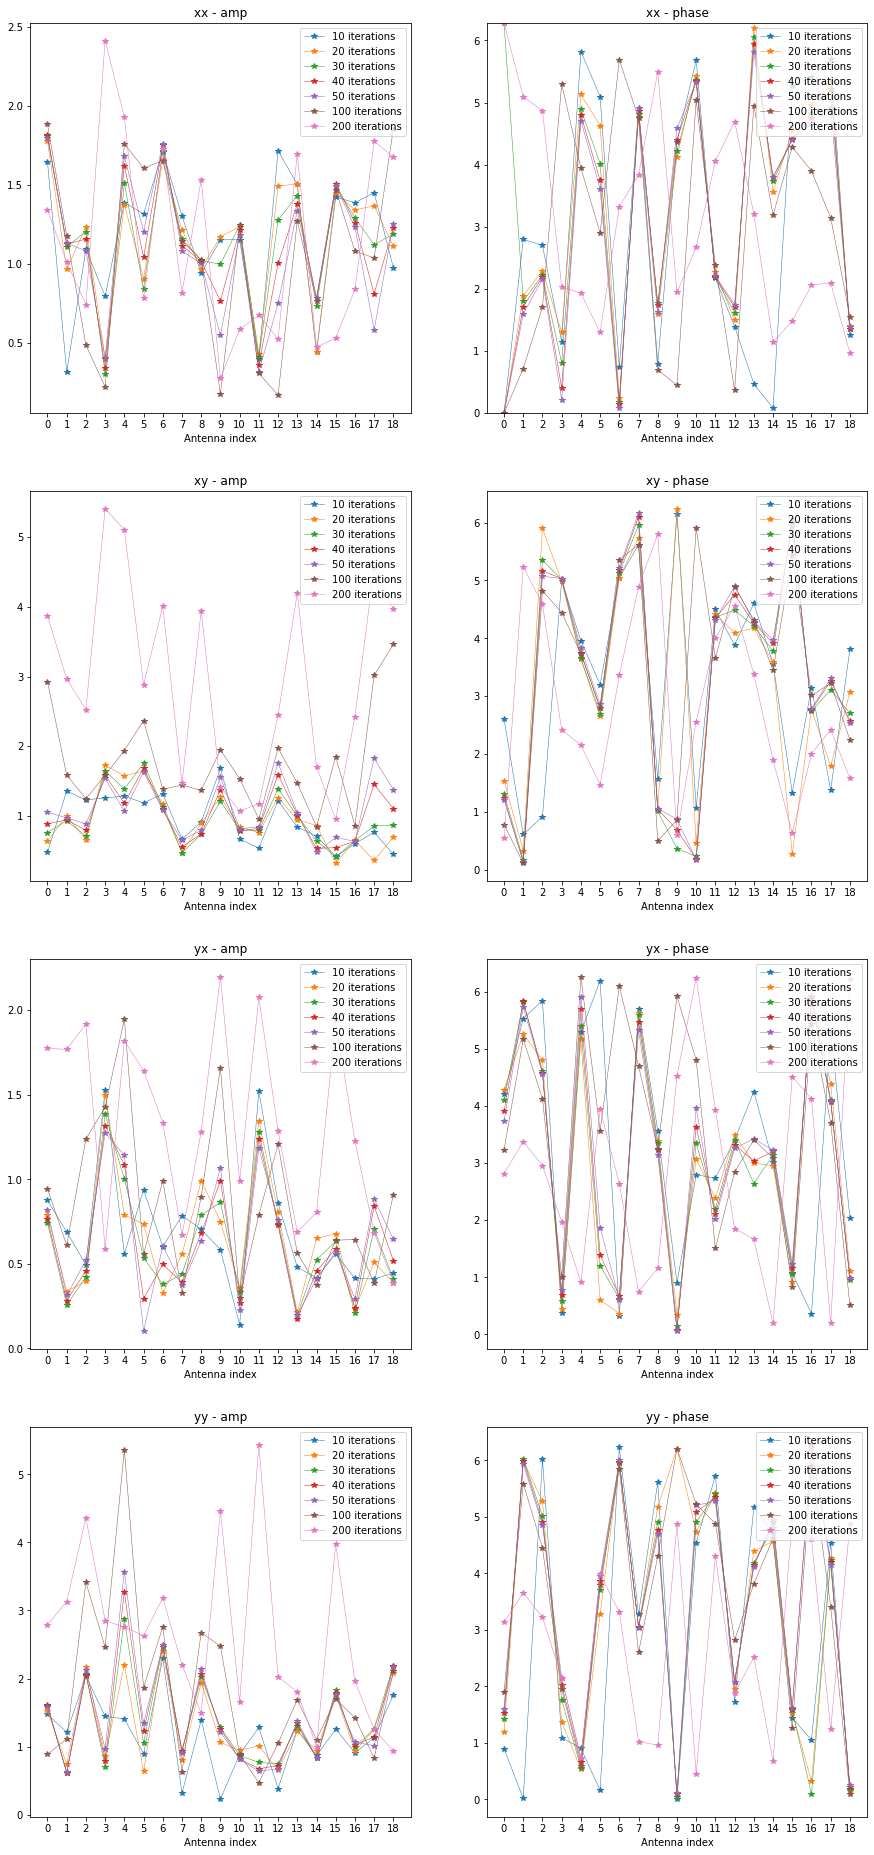

In [59]:
iterations = [10,20,30,40,50,100,200]
fig, axes = plt.subplots(figsize=(15,33), nrows=4, ncols=2)
ax = axes[0,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.legend(loc='upper right')
ax.set_xlabel("Antenna index")
ax.set_title("xx - amp")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[0,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_ylim(0, np.pi*2)
ax.set_xlabel("Antenna index")
ax.set_title("xx - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[1,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[1,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*',label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[2,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[2,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[3,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[3,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

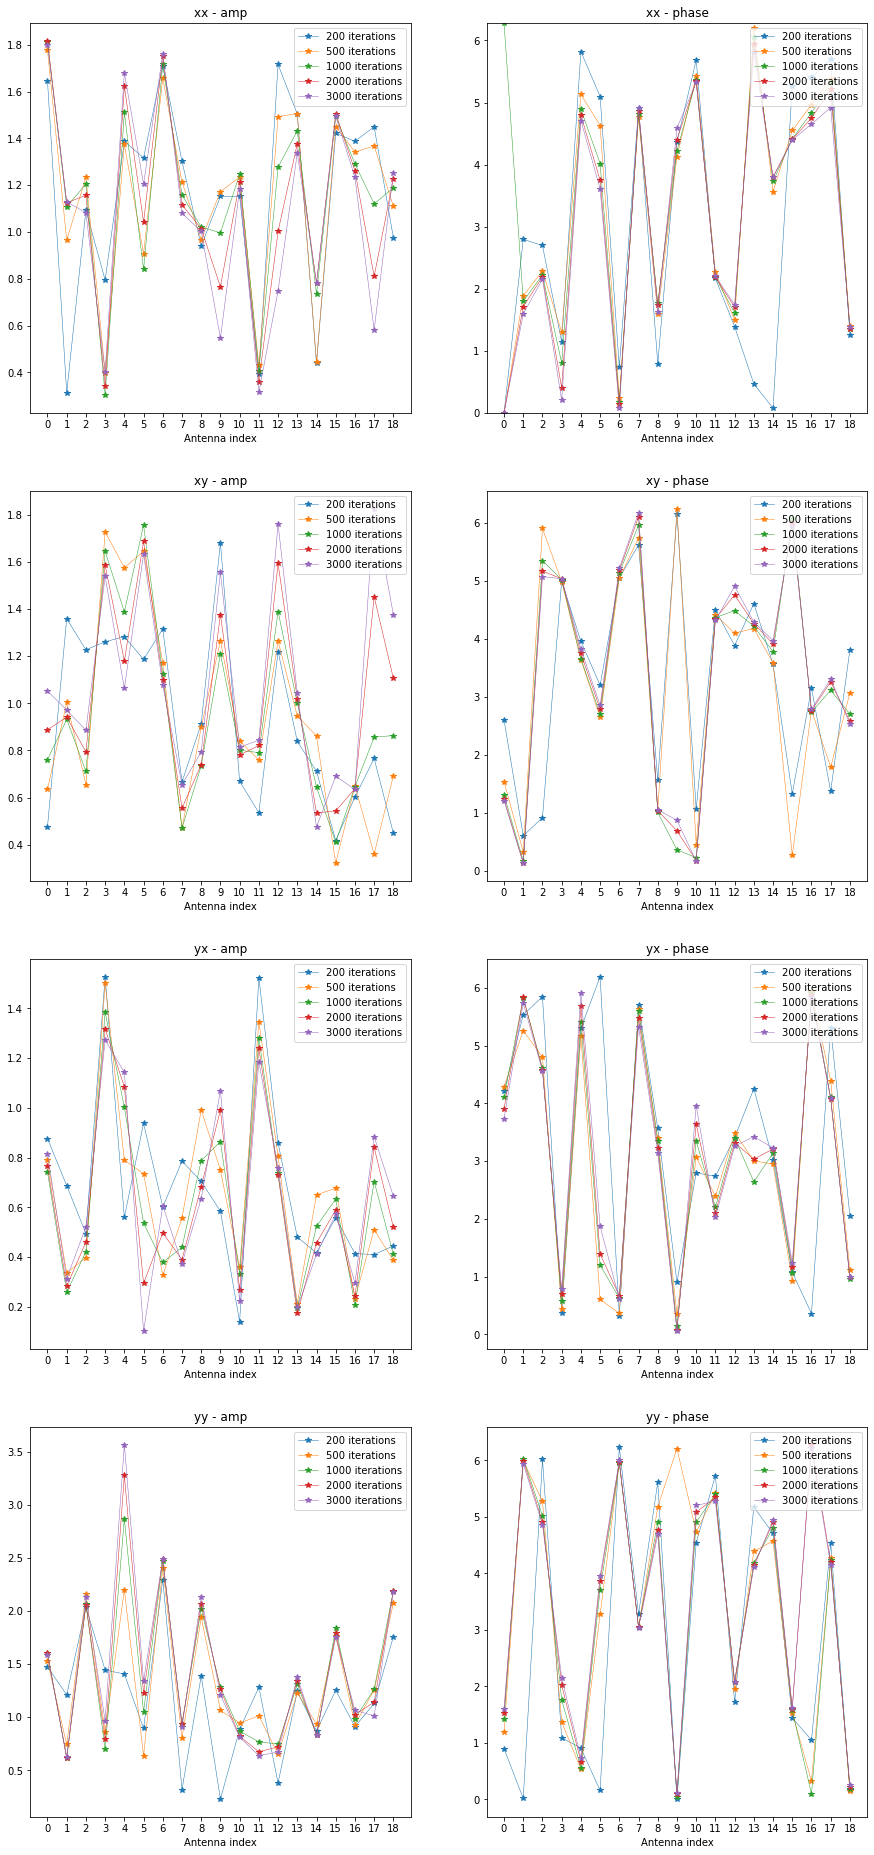

In [61]:
iterations = [200,500,1000,2000,3000]
fig, axes = plt.subplots(figsize=(15,33), nrows=4, ncols=2)
ax = axes[0,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.legend(loc='upper right')
ax.set_xlabel("Antenna index")
ax.set_title("xx - amp")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[0,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_ylim(0, np.pi*2)
ax.set_xlabel("Antenna index")
ax.set_title("xx - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[1,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[1,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*',label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[2,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[2,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[3,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[3,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

### Apply calibration to ~100 frequency channels

In [9]:
gain_array_calibrated = np.load('gain_info_HERA19.npy')

### Visulization of gains per antenna across frequencies

In [16]:
from matplotlib import ticker

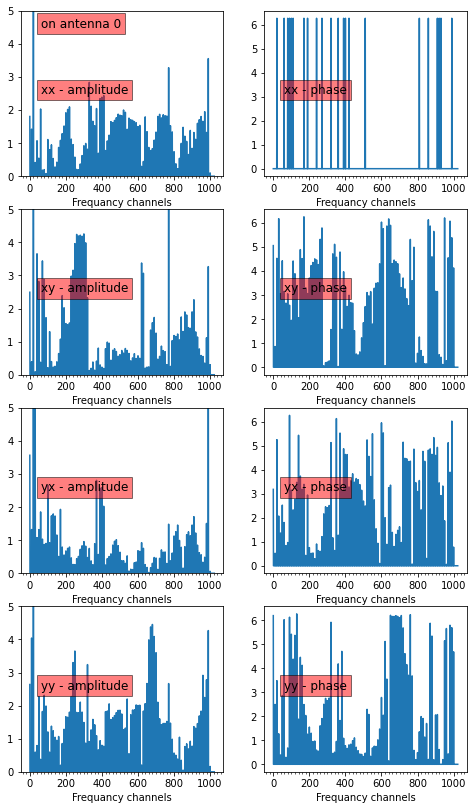

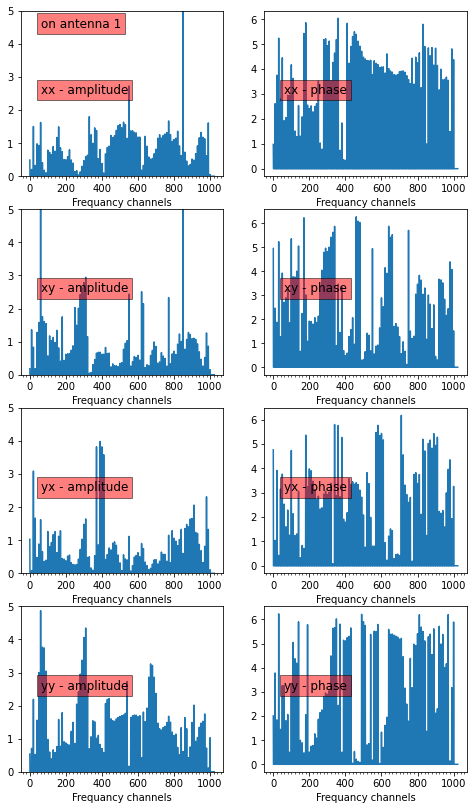

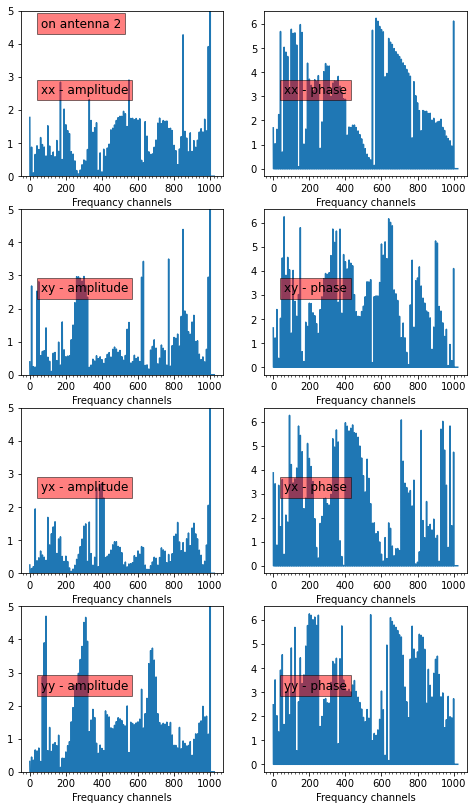

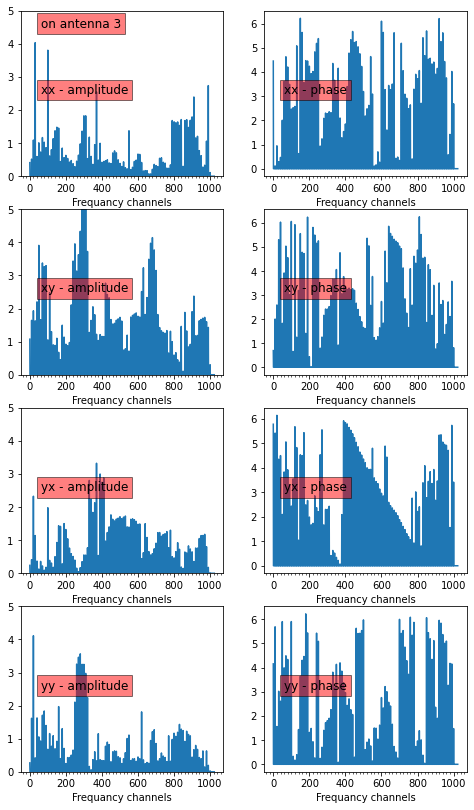

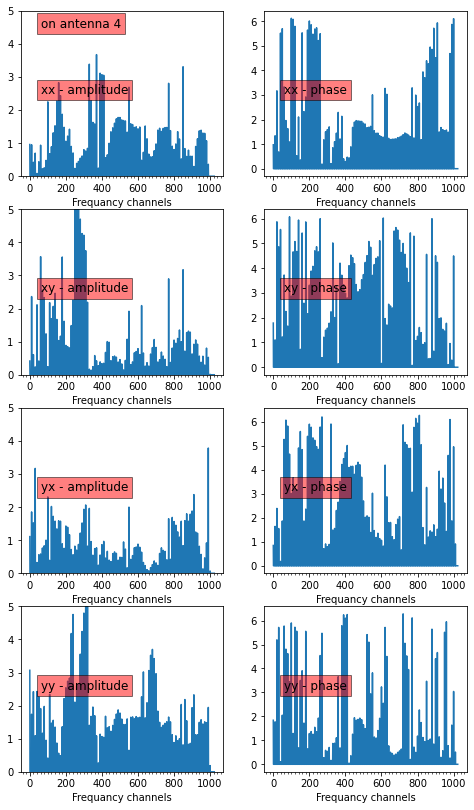

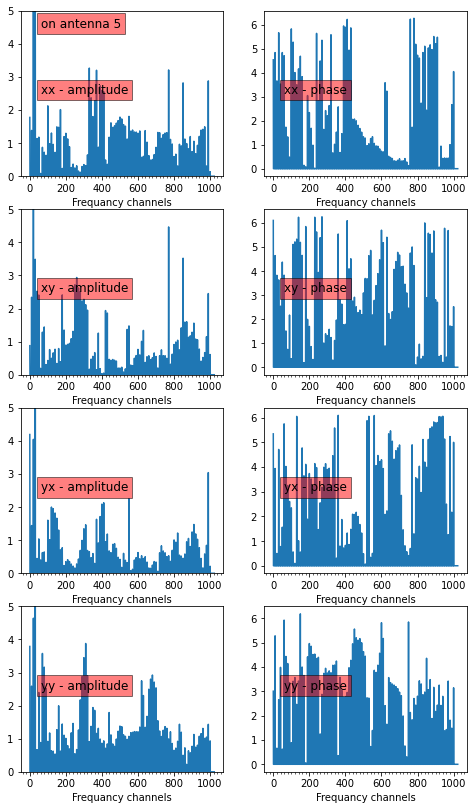

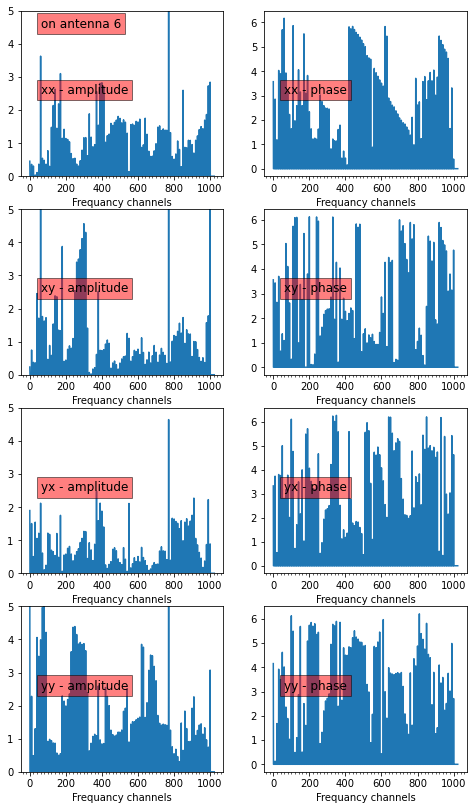

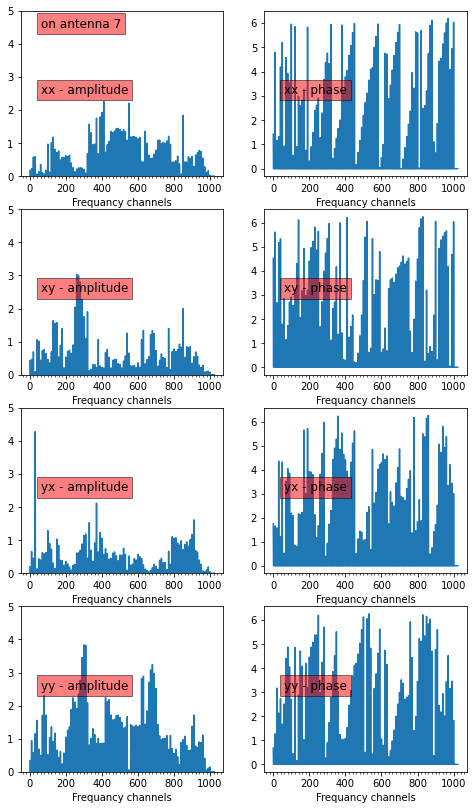

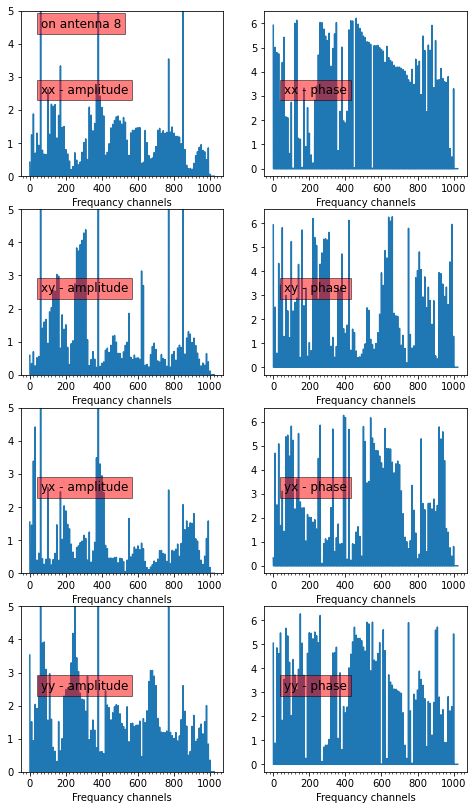

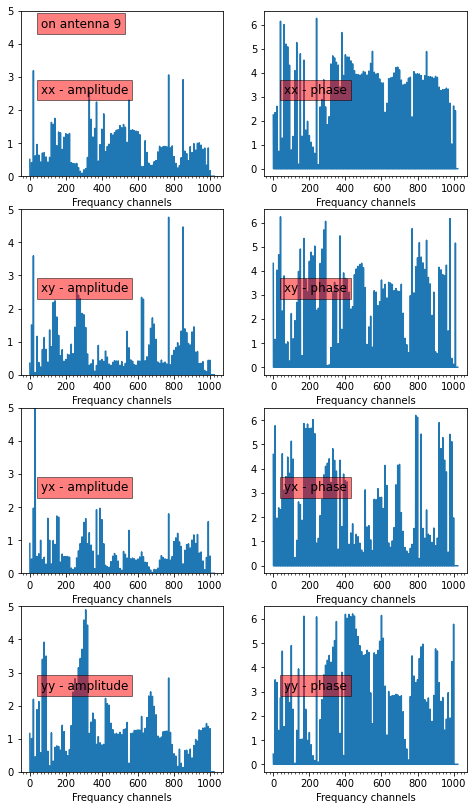

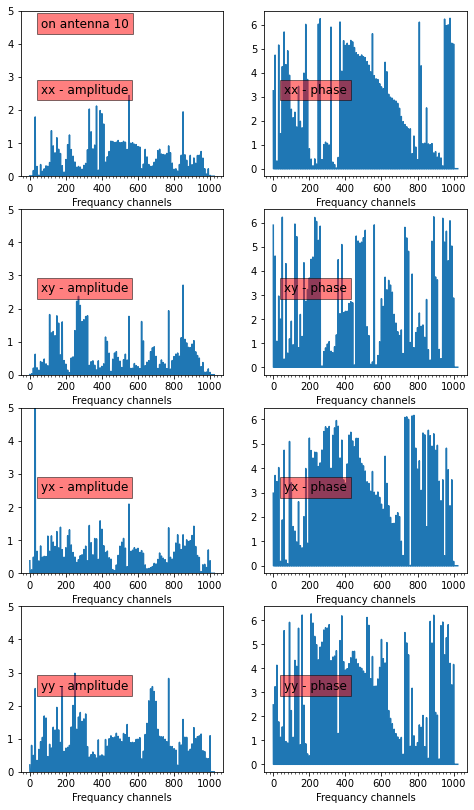

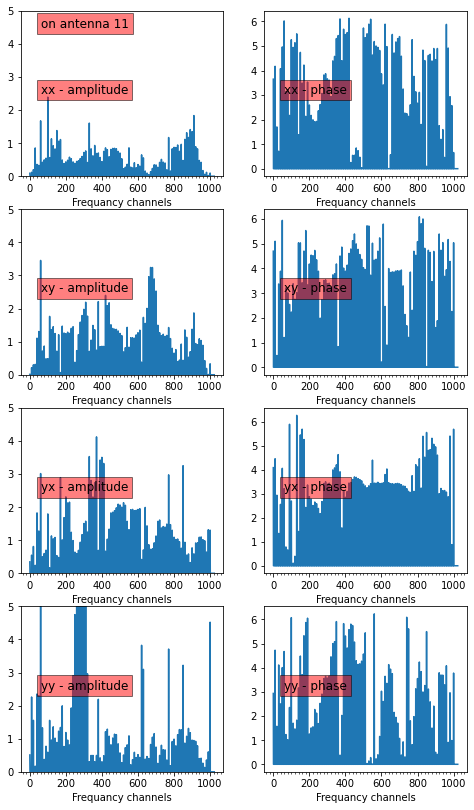

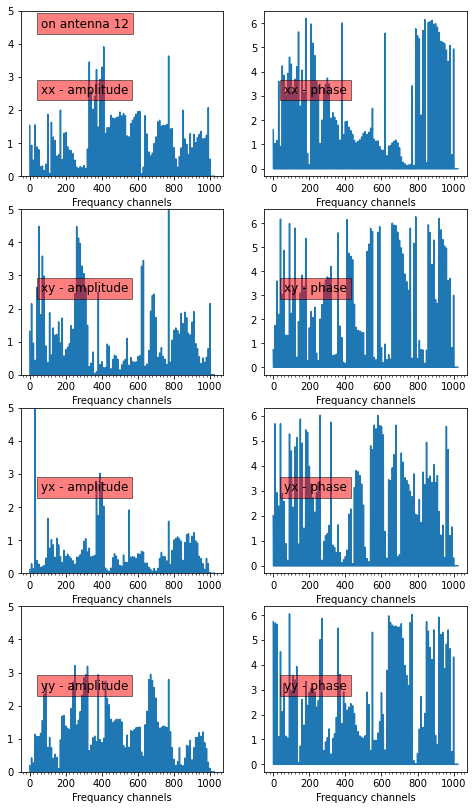

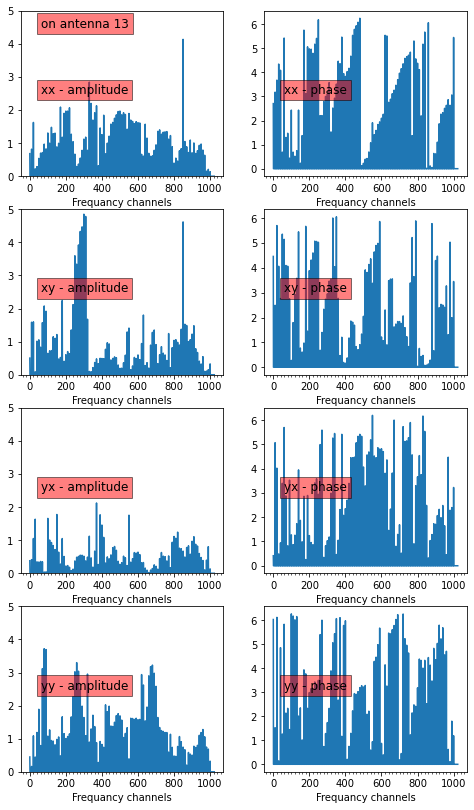

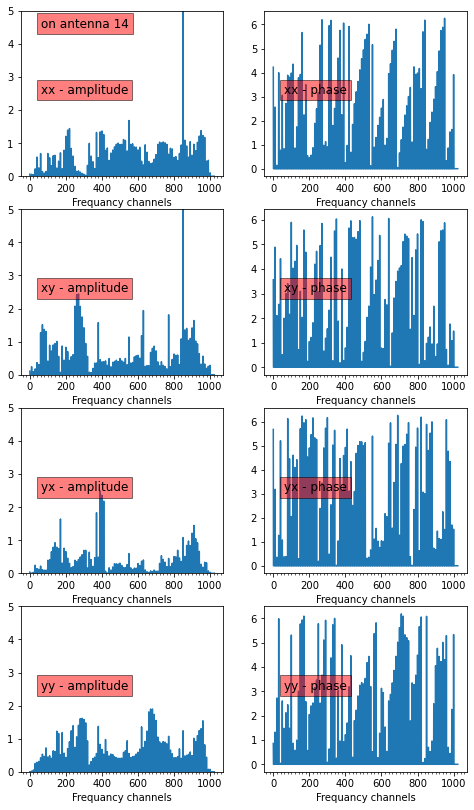

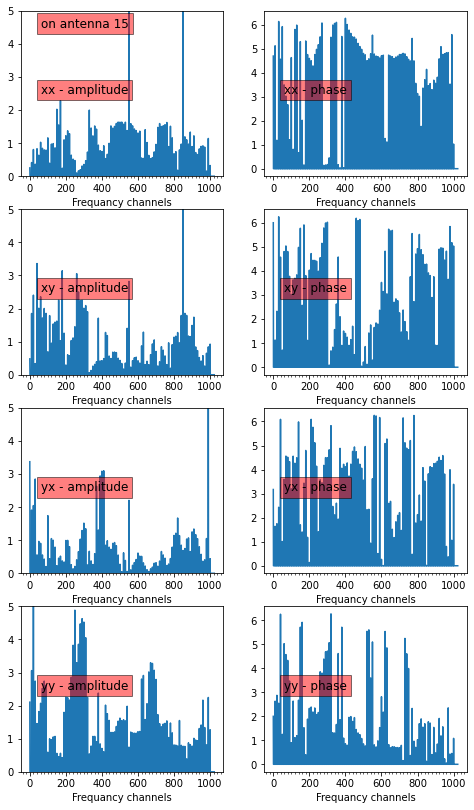

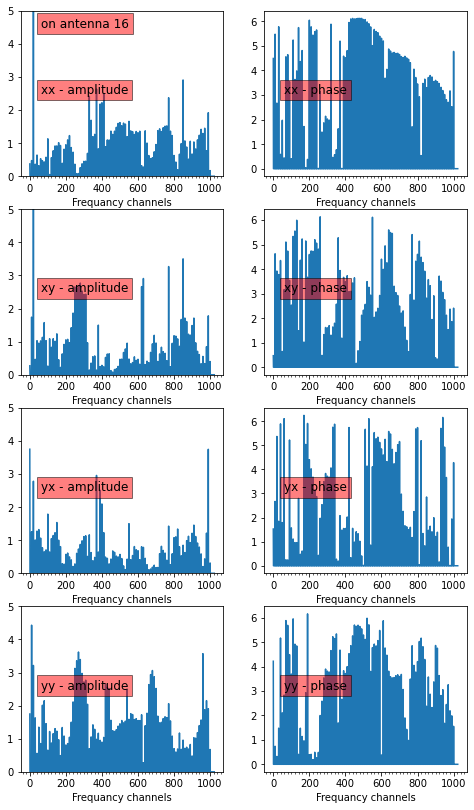

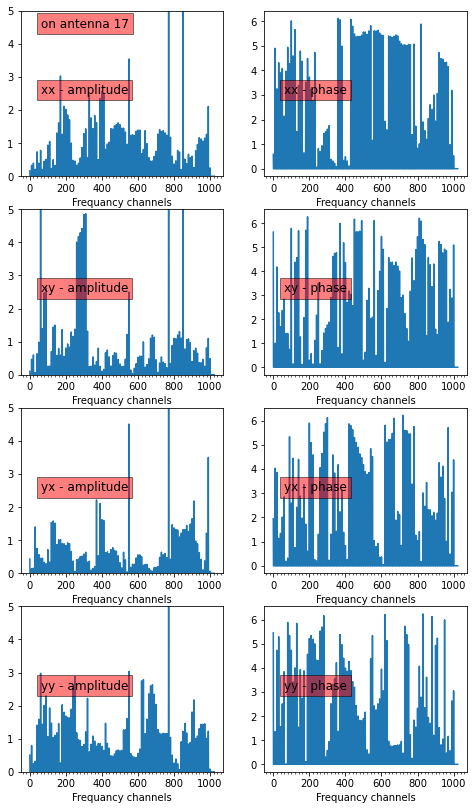

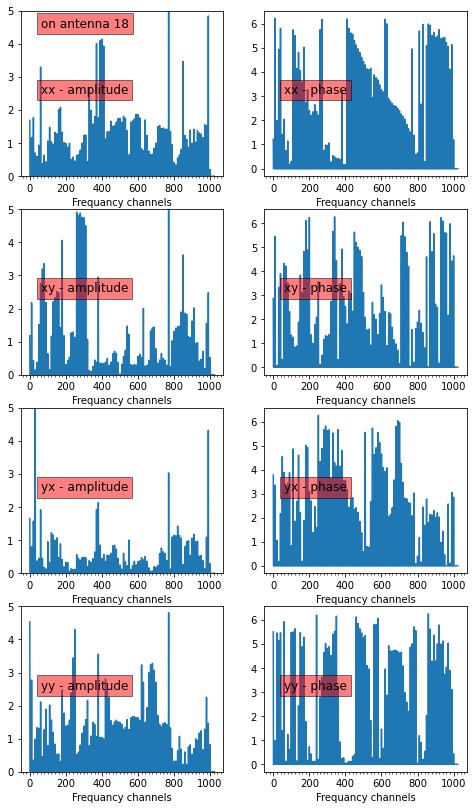

In [21]:
for ant in range(19):
    fig, axes = plt.subplots(figsize=(8,14), nrows=4, ncols=2)
    ax = axes[0,0]
    ax.text(0.1, 0.9, "on antenna {}".format(ant), bbox=dict(facecolor='red', alpha=0.5),fontsize=12, transform=ax.transAxes)
    ax.plot(abs(gain_array_calibrated[ant,:,0,0]))
    ax.set_xlabel("Frequancy channels")
    ax.text(0.1, 0.5, "xx - amplitude", bbox=dict(facecolor='red', alpha=0.5),fontsize=12,transform=ax.transAxes)
    ax.set_ylim(0,5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
    ax = axes[0,1]
    angles = np.angle(gain_array_calibrated[ant,:,0,0])
    angles[np.where(angles<0)] += 2*np.pi
    ax.plot(angles)
    ax.set_xlabel("Frequancy channels")
    ax.text(0.1, 0.5, "xx - phase", bbox=dict(facecolor='red', alpha=0.5),fontsize=12,transform=ax.transAxes)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
    
    ax = axes[1,0]
    ax.plot(abs(gain_array_calibrated[ant,:,0,1]))
    ax.set_xlabel("Frequancy channels")
    ax.text(0.1, 0.5, "xy - amplitude", bbox=dict(facecolor='red', alpha=0.5),fontsize=12,transform=ax.transAxes)
    ax.set_ylim(0,5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
    ax = axes[1,1]
    angles = np.angle(gain_array_calibrated[ant,:,0,1])
    angles[np.where(angles<0)] += 2*np.pi
    ax.plot(angles)
    ax.set_xlabel("Frequancy channels")
    ax.text(0.1, 0.5, "xy - phase", bbox=dict(facecolor='red', alpha=0.5),fontsize=12,transform=ax.transAxes)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))

    ax = axes[2,0]
    ax.plot(abs(gain_array_calibrated[ant,:,1,0]))
    ax.set_xlabel("Frequancy channels")
    ax.text(0.1, 0.5, "yx - amplitude", bbox=dict(facecolor='red', alpha=0.5),fontsize=12,transform=ax.transAxes)
    ax.set_ylim(0,5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
    ax = axes[2,1]
    angles = np.angle(gain_array_calibrated[ant,:,1,0])
    angles[np.where(angles<0)] += 2*np.pi
    ax.plot(angles)
    ax.set_xlabel("Frequancy channels")
    ax.text(0.1, 0.5, "yx - phase", bbox=dict(facecolor='red', alpha=0.5),fontsize=12,transform=ax.transAxes)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))

    ax = axes[3,0]
    ax.plot(abs(gain_array_calibrated[ant,:,1,1]))
    ax.set_xlabel("Frequancy channels")
    ax.text(0.1, 0.5, "yy - amplitude", bbox=dict(facecolor='red', alpha=0.5),fontsize=12,transform=ax.transAxes)
    ax.set_ylim(0,5)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
    ax = axes[3,1]
    angles = np.angle(gain_array_calibrated[ant,:,1,1])
    angles[np.where(angles<0)] += 2*np.pi
    ax.plot(angles)
    ax.set_xlabel("Frequancy channels")
    ax.text(0.1, 0.5, "yy - phase", bbox=dict(facecolor='red', alpha=0.5),fontsize=12,transform=ax.transAxes)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))

### Apply gains back to the raw data, and convert to uvfits

In [45]:
uvd_cal = apply_gains(uvd_raw,
    gain_array_calibrated,
    need_interpolate=True,
    interpolate_freq_index=np.arange(0,1024,10),
    need_inverse=True,
    epsilon=1e-12)

In [47]:
uvd_cal.phase_to_time(raw_start)

In [48]:
uvd_cal.write_uvfits('/lustre/aoc/projects/hera/jtan/HERA19_images/zen.2457555.38268.HH.uvcRP.polcal.uvfits', spoof_nonessential=True, force_phase=True)

### Apply Smirnov method on single frequency channel for 'phase' version?

In [70]:
uv_polcal_sin_phased = uvdata_pol_calibrator(model_data=uvd_sim_copy, real_data=uvd_raw_copy, mode="model_based")

In [71]:
uv_polcal_sin_phased.data_slice(base_time_range=[sim_start, sim_end], prod_time_range=[raw_start,raw_end], 
                             base_freq_range=[300], prod_freq_range=[300], use_all_ants=True)

In [73]:
gain_array_iterations_phased = []
for iteration in [10,20,30,40,50,100,200,500,1000,2000,3000,4000]:
    start_time = time.time()
    uv_polcal_sin_phased.Wirtinger_lm_cal(diagonalize=False, Niteration=iteration)
    print("--- %s seconds ---" % (time.time() - start_time))
    print(uv_polcal_sin_phased.gain_array[0,300])
    gain_array_iterations_phased.append(copy.deepcopy(uv_polcal_sin_phased.gain_array[:,300]))

--- 0.7031149864196777 seconds ---
[[ 1.6441604 +0.j         -0.41111091+0.2430448j ]
 [-0.42480579-0.76711595j  0.91883649+1.1498956j ]]
--- 1.6689062118530273 seconds ---
[[ 1.77511251+0.j          0.02045116+0.63477806j]
 [-0.32731217-0.72125302j  0.56487977+1.41359506j]]
--- 2.3882806301116943 seconds ---
[[ 1.80999946-5.55111512e-17j  0.19441108+7.36758331e-01j]
 [-0.42349678-6.09302651e-01j  0.23671245+1.58010398e+00j]]
--- 3.1989264488220215 seconds ---
[[ 1.81681729+0.j          0.28885011+0.83989227j]
 [-0.55332224-0.52818445j  0.0556124 +1.60495928j]]
--- 3.801203727722168 seconds ---
[[ 1.79905763+0.j          0.36846353+0.98496951j]
 [-0.67752411-0.4543491j  -0.05554502+1.5794522j ]]
--- 7.953615188598633 seconds ---
[[ 1.88106507+0.j          2.08412642+2.05224606j]
 [-0.9399517 -0.08123836j -0.28035374+0.83974745j]]
--- 15.570506572723389 seconds ---
[[ 1.32793995+1.11022302e-16j  3.31873337+1.96832137e+00j]
 [-1.60281374+6.20176566e-01j -2.64360096+1.60087651e-01j]]
--- 

In [75]:
gain_array_iterations_phased = np.array(gain_array_iterations_phased)

#### plot recovered gains versus iterations

In [58]:
from matplotlib import ticker

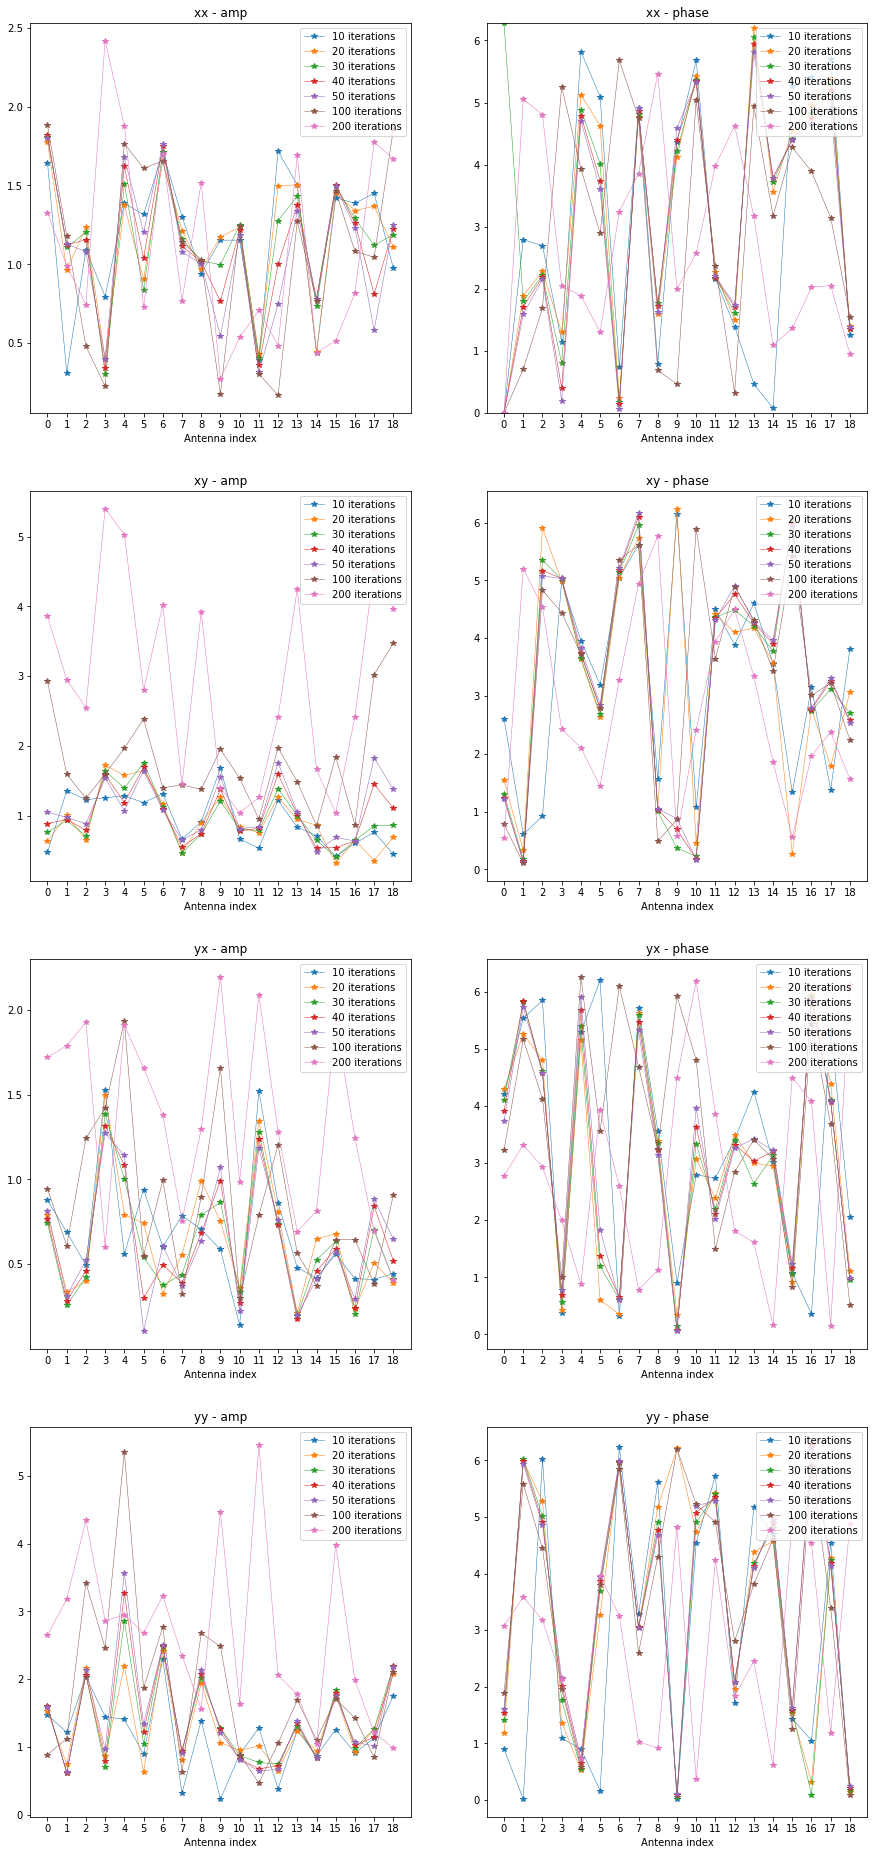

In [76]:
iterations = [10,20,30,40,50,100,200]
fig, axes = plt.subplots(figsize=(15,33), nrows=4, ncols=2)
ax = axes[0,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations_phased[i][:,0,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.legend(loc='upper right')
ax.set_xlabel("Antenna index")
ax.set_title("xx - amp")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[0,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations_phased[i][:,0,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_ylim(0, np.pi*2)
ax.set_xlabel("Antenna index")
ax.set_title("xx - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[1,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations_phased[i][:,0,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[1,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations_phased[i][:,0,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*',label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[2,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations_phased[i][:,1,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[2,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations_phased[i][:,1,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[3,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations_phased[i][:,1,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[3,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations_phased[i][:,1,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

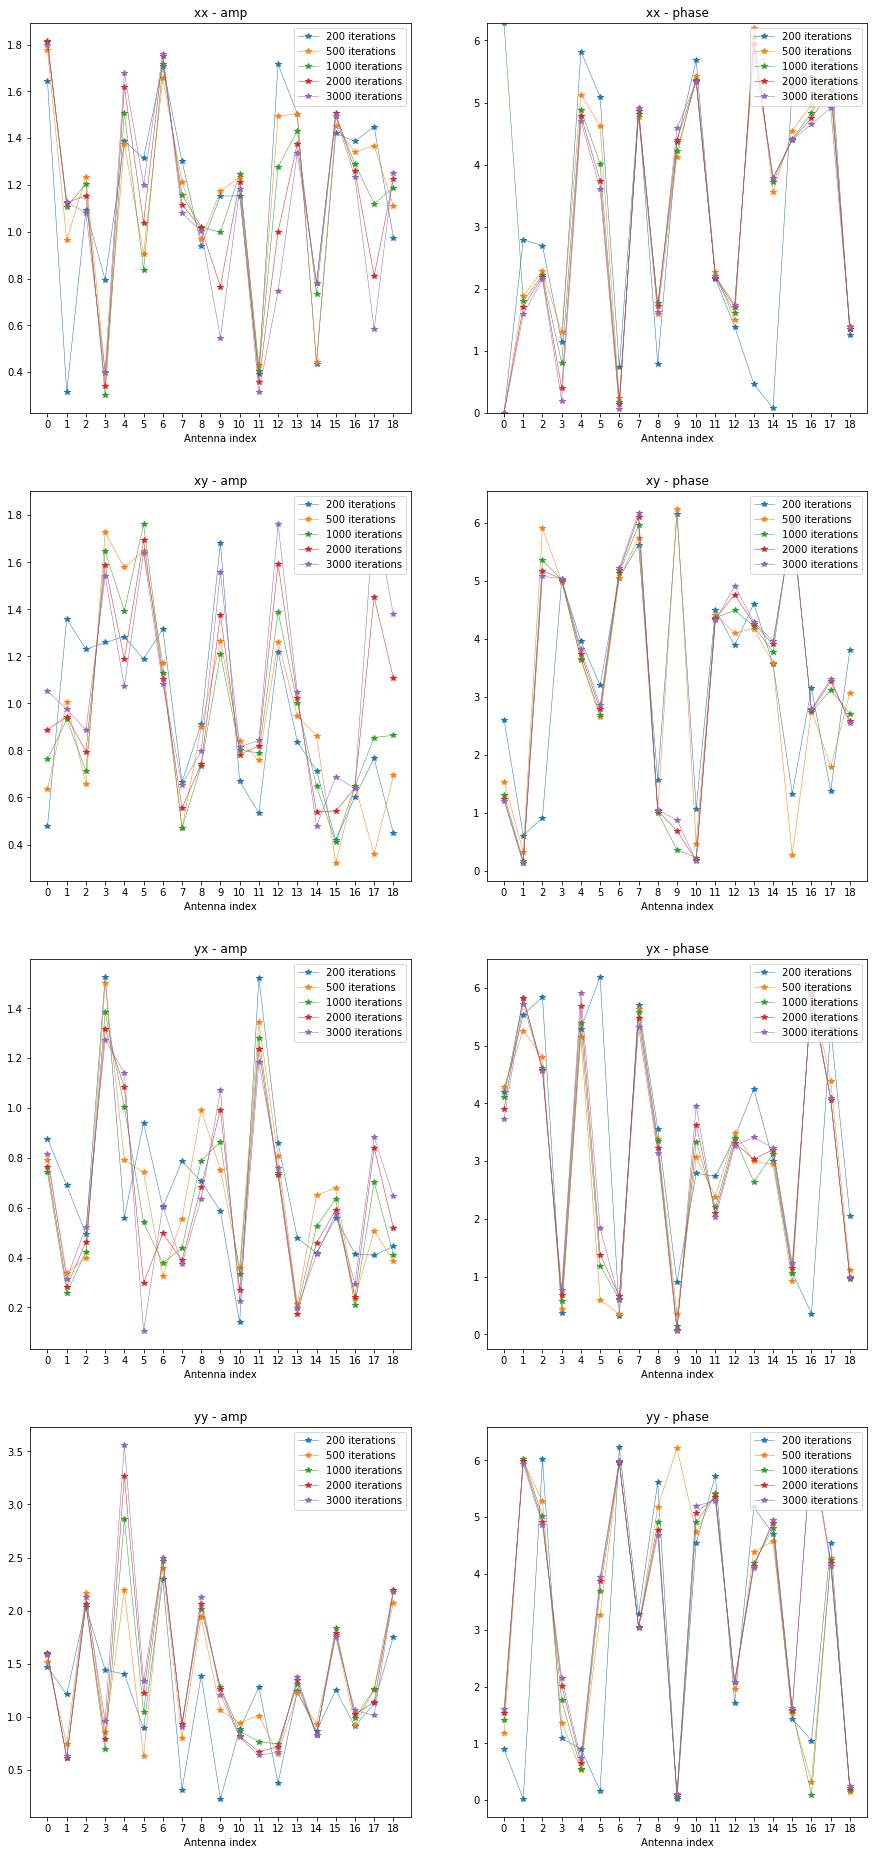

In [77]:
iterations = [200,500,1000,2000,3000]
fig, axes = plt.subplots(figsize=(15,33), nrows=4, ncols=2)
ax = axes[0,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations_phased[i][:,0,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.legend(loc='upper right')
ax.set_xlabel("Antenna index")
ax.set_title("xx - amp")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[0,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations_phased[i][:,0,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_ylim(0, np.pi*2)
ax.set_xlabel("Antenna index")
ax.set_title("xx - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[1,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations_phased[i][:,0,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[1,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations_phased[i][:,0,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*',label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[2,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations_phased[i][:,1,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[2,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations_phased[i][:,1,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[3,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations_phased[i][:,1,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - amp")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax = axes[3,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations_phased[i][:,1,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - phase")
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

### no difference with use of 'phased' version